In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm
from scipy.ndimage import gaussian_filter1d

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(6)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.76:59658 Dashboard: http://10.148.1.76:8787/status,Cluster Workers: 6 Cores: 168 Memory: 720.00 GB


_________
# 1. Read dataset


In [5]:
out_dir_work = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_work+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_work+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_work+'V_total_rechunk.zarr')

ds = xr.merge([ds_U,ds_V,grid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    dxC      (lat, lon_g) float32 ...
    dyC      (lat_g, lon) float32 ...
    dxG      (lat_g, lon) float32 ...
    dyG      (lat, lon_g) float32 ...
    rA

In [6]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'}}, periodic=['X', 'Y'])

In [7]:
# define gaussian filter 
def gaussianfilter(x, sigma, axis):
    
    return xr.apply_ufunc(gaussian_filter1d, x, sigma, axis,
                          dask='parallelized',
                          output_dtypes=[x.dtype])

In [9]:
a_1 = gaussianfilter(ds.U.isel(depth=10), sigma=24, axis=0)
a_7 = gaussianfilter(ds.U.isel(depth=10), sigma=24*7, axis=0)
a_30 = gaussianfilter(ds.U.isel(depth=10), sigma=24*30, axis=0)

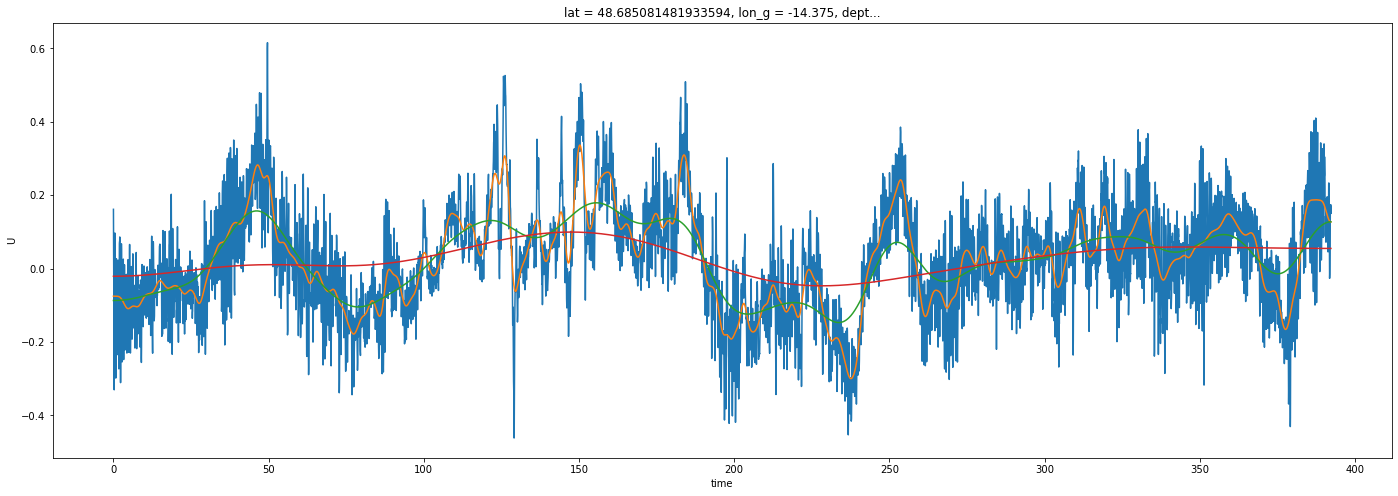

In [10]:
fig, ax = plt.subplots(figsize=(24,8))
ax = plt.subplot(111)
ds.U.isel(depth=10).sel(lat=48.6875,lon_g=343.8125,method='nearest').plot()
a_1.sel(lat=48.6875,lon_g=343.8125,method='nearest').plot()
a_7.sel(lat=48.6875,lon_g=343.8125,method='nearest').plot()
a_30.sel(lat=48.6875,lon_g=343.8125,method='nearest').plot()

________

# At each depth

In [8]:
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/LLC4320/'
depth_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

In [ ]:
sigma = 24*7
VV = ['PI_cg_7']


PI_1 = ( gridx.interp(gaussianfilter(ds.U**2, sigma=sigma, axis=0), 'X') - gridx.interp(gaussianfilter(ds.U, sigma=sigma, axis=0)**2, 'X') )
       * (gridx.diff(gaussianfilter(ds.U, sigma=sigma, axis=0), 'X')/gridx.interp(ds.dxG, 'Y'))

PI_2 = (gridx.interp(gaussianfilter(ds.V**2, sigma=sigma, axis=0), 'Y')-gridx.interp(gaussianfilter(ds.V, sigma=sigma, axis=0)**2, 'Y'))
       * (gridx.diff(gaussianfilter(ds.V, sigma=sigma, axis=0), 'Y')/gridx.interp(ds.dyG, 'X'))

PI_3 = (gaussianfilter(gridx.interp(ds.V,'Y')*gridx.interp(ds.U,'X'), sigma=sigma, axis=0) - gaussianfilter(gridx.interp(ds.V,'Y'), sigma=sigma, axis=0)*gaussianfilter(gridx.interp(ds.U,'X'), sigma=sigma, axis=0) )
        *( gridx.interp(gridx.interp(gridx.diff(gaussianfilter(ds.U, sigma=sigma, axis=0), 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y') + gridx.interp(gridx.interp(gridx.diff(gaussianfilter(ds.V, sigma=sigma, axis=0), 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y') )

PI_cg = -(PI_1+PI_2+PI_3)


In [12]:
sigma = 24*7
VV = ['PI_cg_7']

for depth in depth_all:
    
    for vv in VV:
        
        PI_1 = ( gridx.interp(gaussianfilter(ds.U.isel(depth=depth)**2, sigma=sigma, axis=0), 'X') - gridx.interp(gaussianfilter(ds.U.isel(depth=depth), sigma=sigma, axis=0)**2, 'X') )\
                *(gridx.diff(gaussianfilter(ds.U.isel(depth=depth), sigma=sigma, axis=0), 'X')/gridx.interp(ds.dxG, 'Y'))

        PI_2 = (gridx.interp(gaussianfilter(ds.V.isel(depth=depth)**2, sigma=sigma, axis=0), 'Y')-gridx.interp(gaussianfilter(ds.V.isel(depth=depth), sigma=sigma, axis=0)**2, 'Y'))\
                *(gridx.diff(gaussianfilter(ds.V.isel(depth=depth), sigma=sigma, axis=0), 'Y')/gridx.interp(ds.dyG, 'X'))

        PI_3 = (gaussianfilter(gridx.interp(ds.V.isel(depth=depth),'Y')*gridx.interp(ds.U.isel(depth=depth),'X'), sigma=sigma, axis=0) - gaussianfilter(gridx.interp(ds.V.isel(depth=depth),'Y'), sigma=sigma, axis=0)*gaussianfilter(gridx.interp(ds.U.isel(depth=depth),'X'), sigma=sigma, axis=0) )\
                *( gridx.interp(gridx.interp(gridx.diff(gaussianfilter(ds.U.isel(depth=depth), sigma=sigma, axis=0), 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y') + gridx.interp(gridx.interp(gridx.diff(gaussianfilter(ds.V.isel(depth=depth), sigma=sigma, axis=0), 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y') )

        PI_cg_single = -(PI_1+PI_2+PI_3)

        #PI_cg_single = PI_cg.isel(depth=depth)
        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        PI_cg_single = PI_cg_single.chunk(chunks)
        PI_cg_single = np.real(PI_cg_single).rename('PI_cg_single')     
        PI_cg_single = PI_cg_single.to_dataset()
        
        file_out = store_dir_zarr+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

KeyboardInterrupt: 

In [11]:
sigma = 24*30
VV = ['PI_cg_30']

du_dx = gridx.diff(gaussianfilter(ds.U, sigma=sigma, axis=0), 'X')/gridx.interp(ds.dxG, 'Y')
dv_dy = gridx.diff(gaussianfilter(ds.V, sigma=sigma, axis=0), 'Y')/gridx.interp(ds.dyG, 'X')
du_dy = gridx.interp(gridx.interp(gridx.diff(gaussianfilter(ds.U, sigma=sigma, axis=0), 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(gaussianfilter(ds.V, sigma=sigma, axis=0), 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

PI_1 = (gridx.interp(gaussianfilter(ds.U**2, sigma=sigma, axis=0), 'X')-gridx.interp(gaussianfilter(ds.U, sigma=sigma, axis=0)**2, 'X'))*du_dx
PI_2 = (gridx.interp(gaussianfilter(ds.V**2, sigma=sigma, axis=0), 'Y')-gridx.interp(gaussianfilter(ds.V, sigma=sigma, axis=0)**2, 'Y'))*dv_dy
PI_3 = (gaussianfilter(gridx.interp(ds.V,'Y')*gridx.interp(ds.U,'X'), sigma=sigma, axis=0) - gaussianfilter(gridx.interp(ds.V,'Y'), sigma=sigma, axis=0)*gaussianfilter(gridx.interp(ds.U,'X'), sigma=sigma, axis=0) )*(du_dy+dv_dx)

PI_cg = -(PI_1+PI_2+PI_3)


for depth in depth_all:
    
    for vv in VV:
        
        PI_cg_single = PI_cg.isel(depth=depth)
        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        PI_cg_single = PI_cg_single.chunk(chunks)
        PI_cg_single = np.real(PI_cg_single).rename('PI_cg_single')     
        PI_cg_single = PI_cg_single.to_dataset()
        
        file_out = store_dir_zarr+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<neg, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 199, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [11]:
sigma = 24*60
VV = ['PI_cg_60']

du_dx = gridx.diff(gaussianfilter(ds.U, sigma=sigma, axis=0), 'X')/gridx.interp(ds.dxG, 'Y')
dv_dy = gridx.diff(gaussianfilter(ds.V, sigma=sigma, axis=0), 'Y')/gridx.interp(ds.dyG, 'X')
du_dy = gridx.interp(gridx.interp(gridx.diff(gaussianfilter(ds.U, sigma=sigma, axis=0), 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(gaussianfilter(ds.V, sigma=sigma, axis=0), 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

PI_1 = (gridx.interp(gaussianfilter(ds.U**2, sigma=sigma, axis=0), 'X')-gridx.interp(gaussianfilter(ds.U, sigma=sigma, axis=0)**2, 'X'))*du_dx
PI_2 = (gridx.interp(gaussianfilter(ds.V**2, sigma=sigma, axis=0), 'Y')-gridx.interp(gaussianfilter(ds.V, sigma=sigma, axis=0)**2, 'Y'))*dv_dy
PI_3 = (gaussianfilter(gridx.interp(ds.V,'Y')*gridx.interp(ds.U,'X'), sigma=sigma, axis=0) - gaussianfilter(gridx.interp(ds.V,'Y'), sigma=sigma, axis=0)*gaussianfilter(gridx.interp(ds.U,'X'), sigma=sigma, axis=0) )*(du_dy+dv_dx)

PI_cg = -(PI_1+PI_2+PI_3)


for depth in depth_all:
    
    for vv in VV:
        
        PI_cg_single = PI_cg.isel(depth=depth)
        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        PI_cg_single = PI_cg_single.chunk(chunks)
        PI_cg_single = np.real(PI_cg_single).rename('PI_cg_single')     
        PI_cg_single = PI_cg_single.to_dataset()
        
        file_out = store_dir_zarr+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<neg, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 199, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [11]:
sigma = 30

du_dx = gridx.diff(gaussianfilter(ds.U, sigma=sigma, axis=0), 'X')/gridx.interp(ds.dxG, 'Y')
dv_dy = gridx.diff(gaussianfilter(ds.V, sigma=sigma, axis=0), 'Y')/gridx.interp(ds.dyG, 'X')
du_dy = gridx.interp(gridx.interp(gridx.diff(gaussianfilter(ds.U, sigma=sigma, axis=0), 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(gaussianfilter(ds.V, sigma=sigma, axis=0), 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

PI_1 = (gridx.interp(gaussianfilter(ds.U**2, sigma=sigma, axis=0), 'X')-gridx.interp(gaussianfilter(ds.U, sigma=sigma, axis=0)**2, 'X'))*du_dx
PI_2 = (gridx.interp(gaussianfilter(ds.V**2, sigma=sigma, axis=0), 'Y')-gridx.interp(gaussianfilter(ds.V, sigma=sigma, axis=0)**2, 'Y'))*dv_dy
PI_3 = (gaussianfilter(gridx.interp(ds.V,'Y')*gridx.interp(ds.U,'X'), sigma=sigma, axis=0) - gaussianfilter(gridx.interp(ds.V,'Y'), sigma=sigma, axis=0)*gaussianfilter(gridx.interp(ds.U,'X'), sigma=sigma, axis=0) )*(du_dy+dv_dx)

PI_cg_30 = -(PI_1+PI_2+PI_3)

VV = ['PI_cg_30']

for depth in depth_all:
    
    for vv in VV:
        
        PI_cg_30_single = PI_cg_30.isel(depth=depth)
        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        PI_cg_30_single = PI_cg_30_single.chunk(chunks)
        PI_cg_30_single = np.real(PI_cg_30_single).rename('PI_cg_30_single')     
        PI_cg_30_single = PI_cg_30_single.to_dataset()
        
        file_out = store_dir_zarr+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_30_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<neg, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 199, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [11]:
sigma = 60

du_dx = gridx.diff(gaussianfilter(ds.U, sigma=sigma, axis=0), 'X')/gridx.interp(ds.dxG, 'Y')
dv_dy = gridx.diff(gaussianfilter(ds.V, sigma=sigma, axis=0), 'Y')/gridx.interp(ds.dyG, 'X')
du_dy = gridx.interp(gridx.interp(gridx.diff(gaussianfilter(ds.U, sigma=sigma, axis=0), 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(gaussianfilter(ds.V, sigma=sigma, axis=0), 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

PI_1 = (gridx.interp(gaussianfilter(ds.U**2, sigma=sigma, axis=0), 'X')-gridx.interp(gaussianfilter(ds.U, sigma=sigma, axis=0)**2, 'X'))*du_dx
PI_2 = (gridx.interp(gaussianfilter(ds.V**2, sigma=sigma, axis=0), 'Y')-gridx.interp(gaussianfilter(ds.V, sigma=sigma, axis=0)**2, 'Y'))*dv_dy
PI_3 = (gaussianfilter(gridx.interp(ds.V,'Y')*gridx.interp(ds.U,'X'), sigma=sigma, axis=0) - gaussianfilter(gridx.interp(ds.V,'Y'), sigma=sigma, axis=0)*gaussianfilter(gridx.interp(ds.U,'X'), sigma=sigma, axis=0) )*(du_dy+dv_dx)

PI_cg_60 = -(PI_1+PI_2+PI_3)

VV = ['PI_cg_60']

for depth in depth_all:
    
    for vv in VV:
        
        PI_cg_60_single = PI_cg_60.isel(depth=depth)
        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        PI_cg_60_single = PI_cg_60_single.chunk(chunks)
        PI_cg_60_single = np.real(PI_cg_60_single).rename('PI_cg_60_single')     
        PI_cg_60_single = PI_cg_60_single.to_dataset()
        
        file_out = store_dir_zarr+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_60_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<neg, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 199, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

## 1.2 Read results

In [16]:
out_dir_store = '/home/c11-data/Test_aponte/xiaolong/Parameter/LLC4320/'
D = [xr.open_zarr(out_dir_store+'PI_cg_30_d%02d.zarr'%(depth)) for depth in range(7)]

PI_cg_30 = xr.concat(D, dim='depth')
PI_cg_30 = PI_cg_30.PI_cg_30_single
PI_cg_30

<xarray.DataArray 'PI_cg_30_single' (depth: 7, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(7, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 201, 177), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66

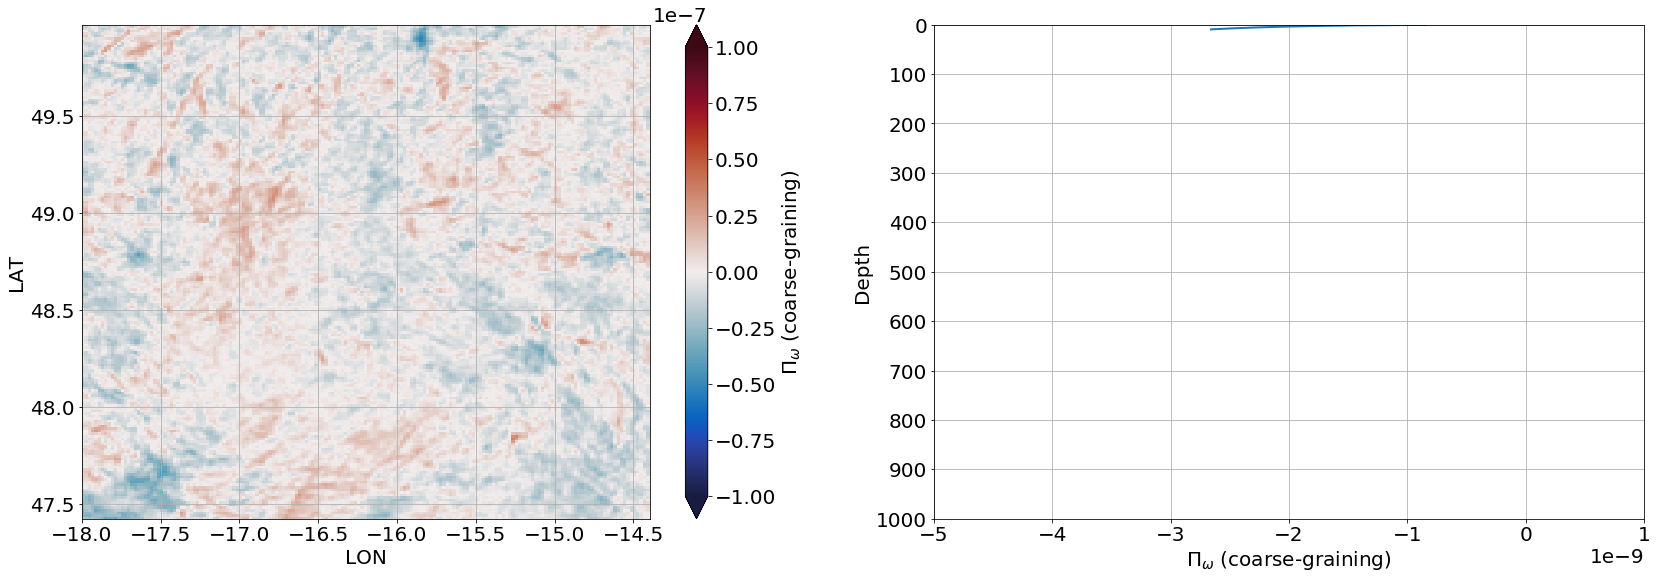

In [19]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(28,20))
ax = plt.subplot(221)
cax = (PI_cg_30).isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(0,6)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-7,vmax=1e-7, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)


ax = plt.subplot(222)
(PI_cg_30).isel(lat=slice(2,-2),lon=slice(2,-2),time=slice(10,-10)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=2)
ax.grid()
ax.set_xlim([-5e-9,1e-9])
ax.set_ylim([1000., 0.])
ax.set_xticks([-5e-9, -4e-9,-3e-9, -2e-9, -1e-9, 0., 1e-9])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])

#plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_together1_coarse_graining.png')

NameError: name 'ds_MLD' is not defined

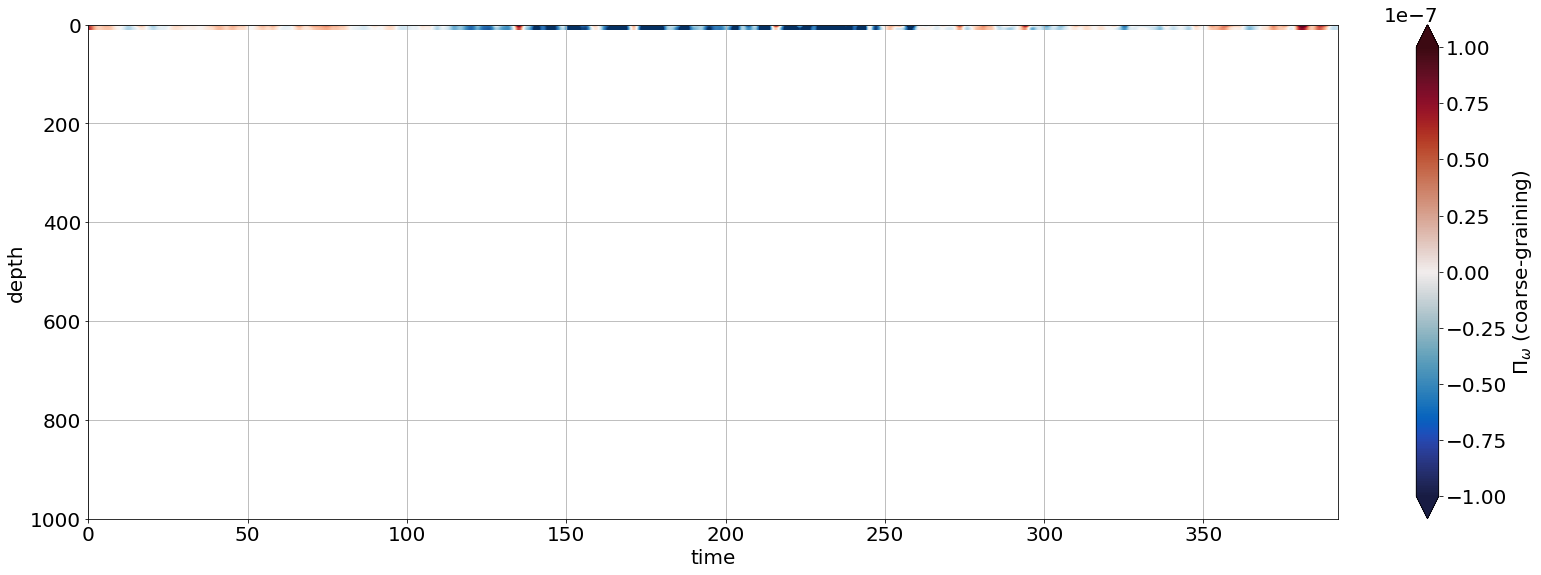

In [20]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,20))

ax = plt.subplot(211)
cbar = (PI_cg_30).isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])


In [13]:
out_dir = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

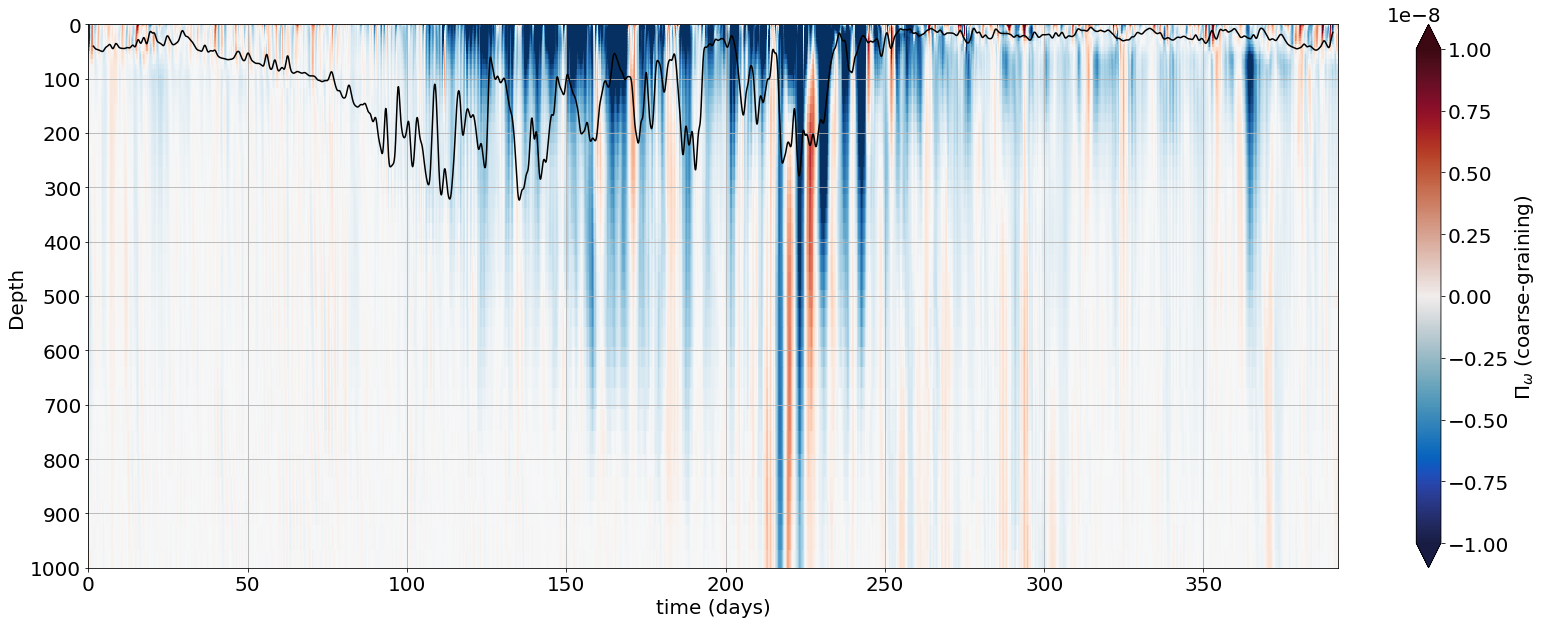

In [14]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,10))

ax = plt.subplot(111)
cbar = (ds_PI.PI_cg_120h-ds_PI.PI_cg_30h).isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])


In [13]:
cluster.close()